# <center>Time Series Analysis on Europlt tower, interpolate from 10 minute data.</center>

## <center>(WORKING)Algorithm: Auto Regressive Integrated Moving Average model(ARIMA)</center>

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import itertools
import warnings
warnings.filterwarnings('ignore')

### Filename

In [3]:
filename ='europlt_processed.csv'

### Data

#### Cleaned tower data from KNMI, Dutch meteorological service, with 10 minutes intervals of wind speed
#### KNMI wind speed and direction observations
#### Europlatform station
#### Lat: 51.9978 Lon: 3.275 z: 29m above mean sea level
#### inititally collected from https://dataplatform.knmi.nl/dataset/windggevens-1-0
#### fields - wind speed FF_10m_10 (m/s)
#### gust speed FF_SENSOR_10 (m/s)
#### wind direction: DDN_10 (degrees)

In [4]:
europlt_wind = pd.read_csv(filename, delimiter=',', header=9)
europlt_wind.head()

,Datetime,LOCATION,NAME,LATITUDE,LONGITUDE,ALTITUDE,FF_10M_10,DD_10,DDN_10,DD_STD_10,DDX_10,FF_SENSOR_10,Flag
0,01/04/2003 00:10,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.15,2.8079,150.5,3.1,3.3094,3.63,1
1,01/04/2003 00:20,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.65,3.2536,153.6,1.9,3.7015,4.06,1
2,01/04/2003 00:30,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.98,3.5478,156.8,1.9,3.9659,4.35,1
3,01/04/2003 00:40,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.18,3.7261,159.9,2.5,4.3032,4.72,1
4,01/04/2003 00:50,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.45,3.9668,164.0,2.8,4.5676,5.01,1


### Set time as the Index

In [5]:
europlt_wind.set_index('Datetime', inplace=True)
europlt_wind.head()

,LOCATION,NAME,LATITUDE,LONGITUDE,ALTITUDE,FF_10M_10,DD_10,DDN_10,DD_STD_10,DDX_10,FF_SENSOR_10,Flag
Datetime,,,,,,,,,,,,
01/04/2003 00:10,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.15,2.8079,150.5,3.1,3.3094,3.63,1
01/04/2003 00:20,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.65,3.2536,153.6,1.9,3.7015,4.06,1
01/04/2003 00:30,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.98,3.5478,156.8,1.9,3.9659,4.35,1
01/04/2003 00:40,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.18,3.7261,159.9,2.5,4.3032,4.72,1
01/04/2003 00:50,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.45,3.9668,164.0,2.8,4.5676,5.01,1


### Choose a month with some NaN values and plot

([<matplotlib.axis.XTick at 0x7ff148944550>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

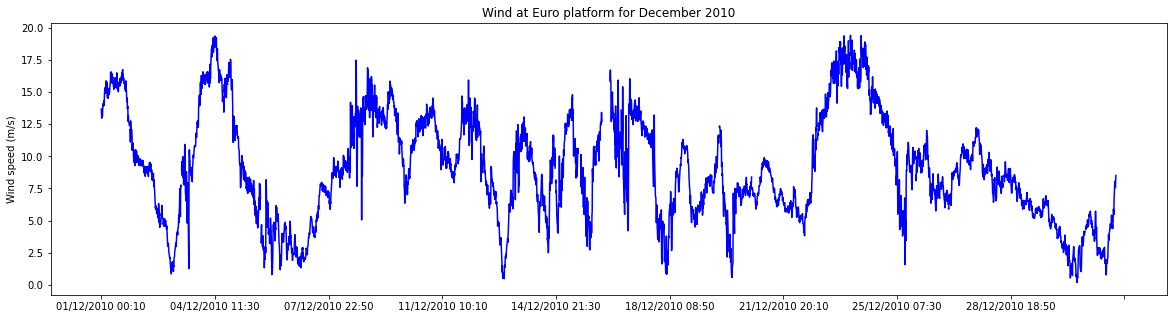

In [6]:
dec_winds = europlt_wind['01/12/2010 00:10':'31/12/2010 23:50']

wind_vals = dec_winds[["FF_10M_10"]].to_numpy()
flags = dec_winds[["Flag"]].to_numpy()

loc_flags = np.where(flags < 1)
wind_vals[loc_flags[0]] = float('NaN')

plt.figure(figsize=(20,5))
plt.plot(dec_winds.index, wind_vals, color='blue')
plt.title('Wind at Euro platform for December 2010')
plt.ylabel('Wind speed (m/s)')
plt.xticks(np.arange(0, 5000, step=500))

### which values are NaN? Can we aim to replace them using ARIMA?

In [7]:
print(dec_winds.index[np.argwhere(flags<1)])
loc_flags[0]

[['01/12/2010 15:00' '01/12/2010 00:10']
 ['01/12/2010 21:00' '01/12/2010 00:10']
 ['02/12/2010 21:00' '01/12/2010 00:10']
 ['03/12/2010 10:50' '01/12/2010 00:10']
 ['03/12/2010 21:00' '01/12/2010 00:10']
 ['04/12/2010 21:00' '01/12/2010 00:10']
 ['05/12/2010 14:30' '01/12/2010 00:10']
 ['05/12/2010 21:00' '01/12/2010 00:10']
 ['06/12/2010 21:00' '01/12/2010 00:10']
 ['08/12/2010 21:00' '01/12/2010 00:10']
 ['09/12/2010 21:00' '01/12/2010 00:10']
 ['10/12/2010 21:00' '01/12/2010 00:10']
 ['11/12/2010 21:00' '01/12/2010 00:10']
 ['12/12/2010 21:00' '01/12/2010 00:10']
 ['13/12/2010 21:00' '01/12/2010 00:10']
 ['14/12/2010 21:00' '01/12/2010 00:10']
 ['15/12/2010 13:50' '01/12/2010 00:10']
 ['15/12/2010 14:00' '01/12/2010 00:10']
 ['15/12/2010 14:10' '01/12/2010 00:10']
 ['15/12/2010 14:20' '01/12/2010 00:10']
 ['15/12/2010 14:30' '01/12/2010 00:10']
 ['15/12/2010 14:40' '01/12/2010 00:10']
 ['15/12/2010 14:50' '01/12/2010 00:10']
 ['15/12/2010 15:00' '01/12/2010 00:10']
 ['15/12/2010 15

array([  89,  125,  269,  352,  413,  557,  662,  701,  845, 1133, 1277,
       1421, 1565, 1709, 1853, 1997, 2098, 2099, 2100, 2101, 2102, 2103,
       2104, 2105, 2106, 2107, 2141, 2203, 2204, 2205, 2206, 2207, 2208,
       2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219,
       2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230,
       2231, 2232, 2233, 2234, 2235, 2236, 2285, 2429, 2573, 2717, 2861,
       2862, 3005, 3073, 3149, 3293, 3437, 3581, 3725, 3869, 3968, 4013,
       4157, 4301, 4328, 4445])

### Next steps:
- ARIMA relies on timeseries repeating behaviour. 
- FInd if the timeseries is auto correlated or partially autocorrelated. 

### ACF and PACF plots

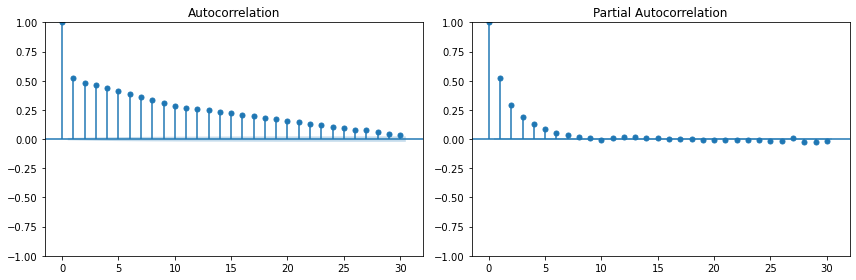

In [8]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(~np.isnan(wind_vals), lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(~np.isnan(wind_vals), lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

-Highly autocorrelated, implies high wind follows high wind and low wind follows low wind - strong trends. 

- If there is seasonality, it will be better if we try all combinations of different parameters and choose the best set ofparameters that gives less AIC score.

### Parameters - p, d, q
- For 10 minute data, set seasonality = 0. 
- try all possible parameters and choose the best set of parameters that gives less AIC score for p and q.

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0, 3)

pq_vals = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

In [10]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [11]:
AIC_scores_list = []

In [56]:
best_aic = np.inf
best_pdq = None
temp_model = None
for param in pdq:
        try:
            
            temp_model = sm.tsa.statespace.SARIMAX(wind_vals,
                                             order = param,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()
            l = []
            l.append(param[0])
            l.append(param[1])
            l.append(param[2])
            l.append(results.aic)
            AIC_scores_list.append(l)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
        except:
            continue

print("Best SARIMAX{} model - AIC:{}".format(best_pdq, best_aic))

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64652D+00    |proj g|=  1.84563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.751D-07   3.646D+00
  F =   3.6464417675628162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3

 This problem is unconstrained.



At iterate    5    f=  2.64287D+00    |proj g|=  7.55537D-02

At iterate   10    f=  2.56120D+00    |proj g|=  7.84722D-03

At iterate   15    f=  2.56086D+00    |proj g|=  2.46172D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     21      1     0     0   2.462D-06   2.561D+00
  F =   2.5608567550734898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11216D+00    |proj g|=  3.46465D-02

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08654D+00    |proj g|=  9.68208D-03

At iterate    5    f=  1.08642D+00    |proj g|=  3.37952D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   3.380D-08   1.086D+00
  F =   1.0864193385608893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.14475D+00    |proj g|=  1.13566D-01

At iterate   10    f=  1.11801D+00    |proj g|=  5.70297D-03

At iterate   15    f=  1.11338D+00    |proj g|=  2.68405D-03

At iterate   20    f=  1.11284D+00    |proj g|=  5.00388D-03

At iterate   25    f=  1.11280D+00    |proj g|=  1.07965D-03

At iterate   30    f=  1.11280D+00    |proj g|=  1.22042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     33     37      1     0     0   5.884D-06   1.113D+00
  F =   1.1127968799791799     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14307D+00    |proj g|=  1.69424D-01

At iterate    5    f=  1.12250D+00    |proj g|=  2.94202D-02

At iterate   10    f=  1.10101D+00    |proj g|=  6.81827D-03

At iterate   15    f=  1.09649D+00    |proj g|=  3.06256D-03

At iterate   20    f=  1.09557D+00    |proj g|=  2.40756D-04

At iterate   25    f=  1.09546D+00    |proj g|=  4.21062D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     34      1     0     0   2.585D-05   1.095D+00
  F =

 This problem is unconstrained.



At iterate    5    f=  1.11217D+00    |proj g|=  6.27211D-04

At iterate   10    f=  1.11216D+00    |proj g|=  2.32266D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     18      1     0     0   2.758D-06   1.112D+00
  F =   1.1121590084582962     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09565D+00    |proj g|=  2.67727D-02


 This problem is unconstrained.



At iterate    5    f=  1.09506D+00    |proj g|=  3.55827D-05

At iterate   10    f=  1.09506D+00    |proj g|=  1.75024D-03

At iterate   15    f=  1.09504D+00    |proj g|=  2.19368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   6.819D-06   1.095D+00
  F =   1.0950333724632944     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08716D+00    |proj g|=  1.66576D-02


 This problem is unconstrained.



At iterate    5    f=  1.08700D+00    |proj g|=  1.99297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   1.993D-05   1.087D+00
  F =   1.0870044661266507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09910D+00    |proj g|=  1.85770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08586D+00    |proj g|=  7.65289D-03

At iterate    5    f=  1.08529D+00    |proj g|=  1.34653D-02

At iterate   10    f=  1.08494D+00    |proj g|=  9.57523D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   9.575D-07   1.085D+00
  F =   1.0849441329156626     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.08473D+00    |proj g|=  3.20794D-04

At iterate   10    f=  1.08472D+00    |proj g|=  3.12406D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   7.577D-06   1.085D+00
  F =   1.0847192036680271     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36833D+00    |proj g|=  7.68975D-03

At iterate    5    f=  1.36830D+00    |proj g|=  3.92604D-06

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18720D+00    |proj g|=  1.66459D-01

At iterate    5    f=  1.12299D+00    |proj g|=  2.44365D-02

At iterate   10    f=  1.10432D+00    |proj g|=  2.38017D-02

At iterate   15    f=  1.10041D+00    |proj g|=  6.99904D-03

At iterate   20    f=  1.09996D+00    |proj g|=  2.50886D-03

At iterate   25    f=  1.09993D+00    |proj g|=  3.54459D-04

At iterate   30    f=  1.09993D+00    |proj g|=  1.85767D-04

At iterate   35    f=  1.09993D+00    |proj g|=  3.29777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14637D+00    |proj g|=  1.18062D-01

At iterate    5    f=  1.13043D+00    |proj g|=  1.23717D-01

At iterate   10    f=  1.11345D+00    |proj g|=  1.09657D-03

At iterate   15    f=  1.11288D+00    |proj g|=  7.88642D-03

At iterate   20    f=  1.11267D+00    |proj g|=  2.40280D-03

At iterate   25    f=  1.11265D+00    |proj g|=  4.73113D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08833D+00    |proj g|=  2.36297D-02


 This problem is unconstrained.



At iterate    5    f=  1.08674D+00    |proj g|=  2.11340D-02

At iterate   10    f=  1.08572D+00    |proj g|=  4.84823D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   4.848D-06   1.086D+00
  F =   1.0857157193358873     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08558D+00    |proj g|=  1.92119D-02


 This problem is unconstrained.



At iterate    5    f=  1.08546D+00    |proj g|=  2.81889D-03

At iterate   10    f=  1.08541D+00    |proj g|=  2.70238D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   2.694D-05   1.085D+00
  F =   1.0854107987334798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09082D+00    |proj g|=  1.79014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   1.643D-05   1.091D+00
  F =   1.0908215788728823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.



At iterate    5    f=  1.08483D+00    |proj g|=  3.06548D-03

At iterate   10    f=  1.08471D+00    |proj g|=  3.14104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   4.395D-06   1.085D+00
  F =   1.0847108757244144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08488D+00    |proj g|=  4.09382D-03


 This problem is unconstrained.



At iterate    5    f=  1.08480D+00    |proj g|=  6.56595D-03

At iterate   10    f=  1.08478D+00    |proj g|=  1.02877D-03

At iterate   15    f=  1.08470D+00    |proj g|=  2.19994D-02

At iterate   20    f=  1.08424D+00    |proj g|=  9.24298D-04

At iterate   25    f=  1.08423D+00    |proj g|=  1.15291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   3.797D-05   1.084D+00
  F =   1.0842254285322550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   5.261D-06   1.292D+00
  F =   1.2922305880388734     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18655D+00    |proj g|=  1.68285D-01


 This problem is unconstrained.



At iterate    5    f=  1.13119D+00    |proj g|=  6.51567D-02

At iterate   10    f=  1.09767D+00    |proj g|=  2.15358D-02

At iterate   15    f=  1.09252D+00    |proj g|=  7.87612D-03

At iterate   20    f=  1.09176D+00    |proj g|=  3.11672D-04

At iterate   25    f=  1.09169D+00    |proj g|=  4.21894D-04

At iterate   30    f=  1.09169D+00    |proj g|=  6.53640D-04

At iterate   35    f=  1.09169D+00    |proj g|=  6.59393D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     56      1     0     0   6.594D-05   1.092D+00
  F =   1.0916852858990249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.14561D+00    |proj g|=  6.75474D-02

At iterate   10    f=  1.10175D+00    |proj g|=  2.27643D-02

At iterate   15    f=  1.09851D+00    |proj g|=  5.98346D-03

At iterate   20    f=  1.09844D+00    |proj g|=  4.63926D-03

At iterate   25    f=  1.09840D+00    |proj g|=  1.54817D-04

At iterate   30    f=  1.09840D+00    |proj g|=  4.79615D-04

At iterate   35    f=  1.09839D+00    |proj g|=  5.43996D-03

At iterate   40    f=  1.09835D+00    |proj g|=  3.90825D-04

At iterate   45    f=  1.09833D+00    |proj g|=  7.48949D-04

At iterate   50    f=  1.09833D+00    |proj g|=  2.44286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [57]:
print(AIC_scores_list)
print(best_pdq)
print(best_aic)

#AIC_scores = pd.DataFrame.from_records(AIC_scores_list)
#AIC_scores.columns=['p', 'd', 'q', 'AIC']
#AIC_scores.iloc[AIC_scores['AIC'].argmin()]

[[0, 0, 0, 12585.701287405518], [0, 0, 1, 7462.178833442966], [0, 0, 2, 4094.167742168], [0, 1, 0, -5507.418650011531], [0, 1, 1, -7298.481469251088], [0, 1, 2, -7301.935009202252], [0, 2, 0, -723.2416739910032], [0, 2, 1, -5494.706124241803], [0, 2, 2, -7282.802781227273], [1, 0, 0, -5521.973990407101], [1, 0, 1, -7294.432868083867], [1, 0, 2, -7297.972071616947], [1, 1, 0, -6568.762357259179], [1, 1, 1, -7302.276690789444], [1, 1, 2, -7402.568926423198], [1, 2, 0, -3201.8380457101234], [1, 2, 1, -6555.118931875872], [1, 2, 2, -7286.486739578639], [2, 0, 0, -6571.108884321922], [2, 0, 1, -7298.230311337089], [2, 0, 2, -7292.271405929657], [2, 1, 0, -6947.001925577102], [2, 1, 1, -7302.608256450197], [2, 1, 2, -7392.750342605882], [2, 2, 0, -4394.300955010533], [2, 2, 1, -6932.664558580265], [2, 2, 2, -7275.502425466201], [0, 0, 0, 32550.1392172657], [0, 0, 1, 27010.654214567312], [0, 0, 2, 22864.20739578597], [0, 1, 0, 9927.689733974716], [0, 1, 1, 9774.265666270612], [0, 1, 2, 9703.3

### Analysis:
- After fitting the data with different combination of models, we got the best parameters as following:
    - p = 2, d = 1, q = 2
    

In [12]:
best_pdq = (2, 1, 2)

### Use the best parameters and build a model

In [13]:
best_model = sm.tsa.statespace.SARIMAX(wind_vals,
                                      order=best_pdq,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()
show_me = 1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08488D+00    |proj g|=  4.09382D-03

At iterate    5    f=  1.08480D+00    |proj g|=  6.56595D-03

At iterate   10    f=  1.08478D+00    |proj g|=  1.02877D-03

At iterate   15    f=  1.08470D+00    |proj g|=  2.19994D-02

At iterate   20    f=  1.08424D+00    |proj g|=  9.24298D-04

At iterate   25    f=  1.08423D+00    |proj g|=  1.15291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   

In [14]:
print(best_results.summary().tables[0])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4463
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4838.898
Date:                Wed, 20 Apr 2022   AIC                           9687.796
Time:                        10:32:22   BIC                           9719.813
Sample:                             0   HQIC                          9699.082
                               - 4463                                         
Covariance Type:                  opg                                         


### Get predictions for points with missing data (see loc_flags) 

In [107]:
pred_dynamic = best_results.get_prediction(start=2200, end=2300, dynamic=True)
predict_df = pred_dynamic.summary_frame(alpha=0.10)

pred2 = best_results.get_prediction(start=2097, end=2110, dynamic=True)
pred_df2 = pred2.summary_frame(alpha=0.10)

### Extract the predicted and true values of our time series

In [95]:
predict_df.index
predict_df['mean']

0      12.872225
1      12.805348
2      12.757728
3      12.750802
4      12.732671
         ...    
96     12.730192
97     12.730414
98     12.730201
99     12.730405
100    12.730209
Name: mean, Length: 101, dtype: float64

### Compute the mean square error

In [104]:
mse = math.sqrt(((wind_predicted - wind_truth) ** 2).mean())
print('The Mean Squared Error of our predictions is {}'.format(round(mse, 4)))


The Mean Squared Error of our predictions is 0.1341


Index(['01/12/2010 00:10', '02/12/2010 09:30', '03/12/2010 18:50',
       '05/12/2010 04:10', '06/12/2010 13:30'],
      dtype='object', name='Datetime')

([<matplotlib.axis.XTick at 0x7f9dd42d3880>,
 [Text(0, 0, '11/12/2010 10:10'),
  Text(200, 0, '12/12/2010 19:30'),
  Text(400, 0, '14/12/2010 04:50'),
  Text(600, 0, '15/12/2010 14:10'),
  Text(800, 0, '16/12/2010 23:30')])

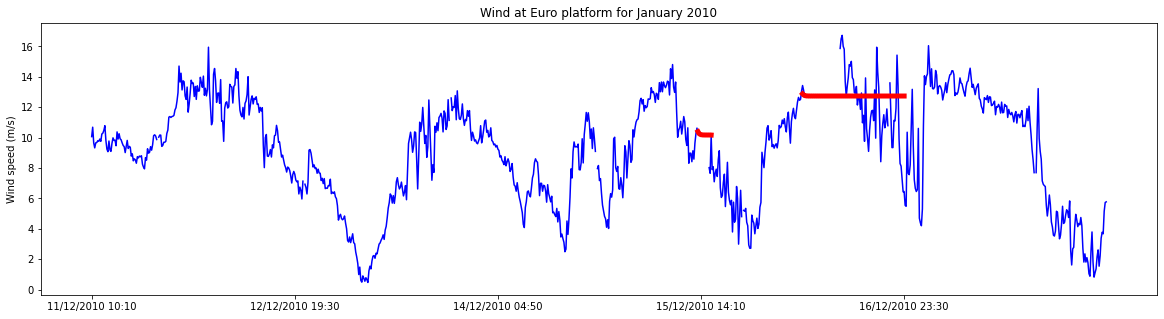

In [114]:
# Plot the actual values.
plt.figure(figsize=(20,5))
plt.plot(wind_vals[1500:2500], color='blue')
plt.plot(np.arange(700,801),predict_df['mean'], color='red', linewidth=5)
plt.plot(np.arange(597,611),pred_df2['mean'], color='red', linewidth=5)
plt.title('Wind at Euro platform for January 2010')
plt.ylabel('Wind speed (m/s)')
plt.xticks(np.arange(0, 1000, step=200),dec_winds.index[np.arange(1500, 2500, step=200)])

### Forecast
- Predict Precipitation for next 7 years.

In [46]:
# Get forecast 96 steps (8 years) ahead in future
n_steps = 96
pred_uc_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% of the forecasts
pred_ci_95 = pred_uc_95.conf_int()

In [47]:
# index = pd.date_range(rainfall_data.index[-1] + 1, periods=n_steps, freq='MS')
index = pd.date_range(rainfall_data.index[-1] + 1*rainfall_data.index[-1].freq, periods=n_steps, freq='MS')
forecast_data = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=index, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

forecast_data.head()

,forecast,lower_ci_95,upper_ci_95
1995-01-01,11.753433,-173.841143,197.348008
1995-02-01,12.528777,-173.065841,198.123395
1995-03-01,13.425796,-172.168843,199.020434
1995-04-01,23.487771,-162.106888,209.082430
1995-05-01,38.512415,-147.082264,224.107094


### Plot the forecast along with confidence band

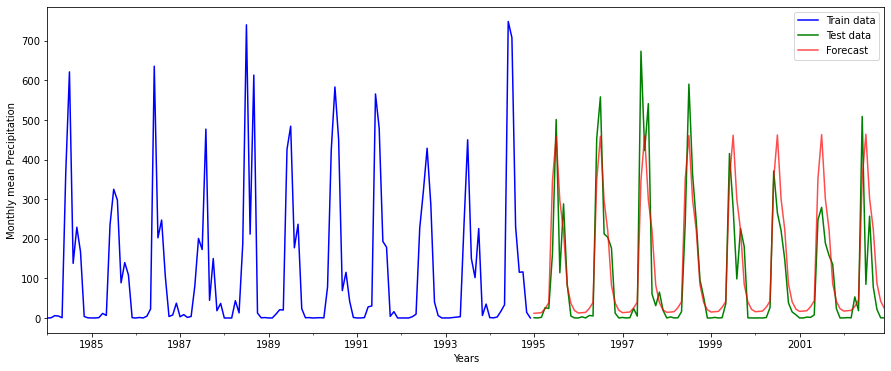

In [48]:
axis_plt = rainfall_dummy_data['1984':].plot(label='Observed', color='blue', figsize=(15, 6))

test_rainfall_data.Precipitation.plot(ax=axis_plt, color='green', label='Test data')
forecast_data['forecast'].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

# axis_plt.fill_between(forecast_data.index, forecast_data['lower_ci_95'], forecast_data['upper_ci_95'], color='k', alpha=.25)

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [49]:
dummy_test_data = test_rainfall_data
dummy_test_data.columns = ['Test data']

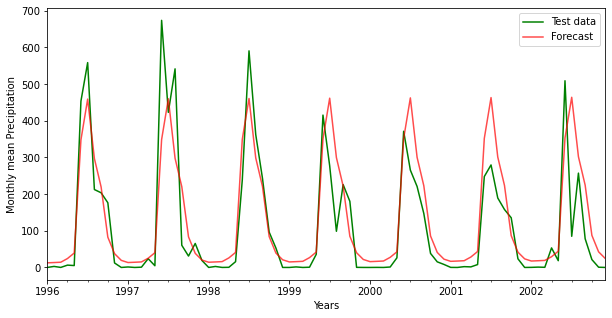

In [50]:
axis_plt = dummy_test_data['1996':].plot(label='Actual values', figsize=(10, 5), color='green')
forecast_data['forecast']['1996':].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

### Mean square error of the forecasts

In [51]:
y_true = test_rainfall_data['1995-01-01':]['Test data']
y_forecast = forecast_data['forecast']

In [52]:
mse = math.sqrt(((y_true - y_forecast) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 89.2525


### MAPE

In [53]:
mape = np.mean(np.abs((y_true - y_forecast) / (y_true))) * 100
print('The MAPE of our forecasts is {}'.format(round(mape, 4)))

The MAPE of our forecasts is inf


In [54]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [55]:
mape_vectorized_v2(y_true, y_forecast)

158.000619460752

In [56]:
RMSE_data = [['Train RMSE', 97.66, 74.58],
            ['Test RMSE', 89.25, 91.69]]

In [57]:
RMSE_data_df = pd.DataFrame.from_records(RMSE_data)
RMSE_data_df.columns = ['Type of Data', 'RMSE of ARIMA', 'RMSE of LSTM']
RMSE_data_df

,Type of Data,RMSE of ARIMA,RMSE of LSTM
0,Train RMSE,97.66,74.58
1,Test RMSE,89.25,91.69


Text(0.5, 1.0, 'ARIMA - Train and Test RMSE')

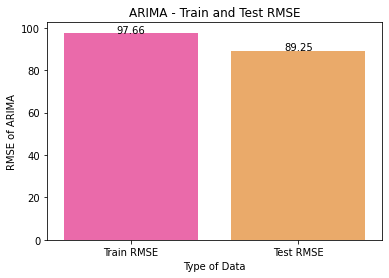

In [58]:
g = sns.barplot(x='Type of Data', y='RMSE of ARIMA', data=RMSE_data_df, palette='spring')
for index, row in RMSE_data_df.iterrows():
    g.text(row.name, row['RMSE of ARIMA'], round(row['RMSE of ARIMA'],2), color='black', ha="center")
plt.title('ARIMA - Train and Test RMSE')

Text(0.5, 1.0, 'LSTM - Train and Test RMSE')

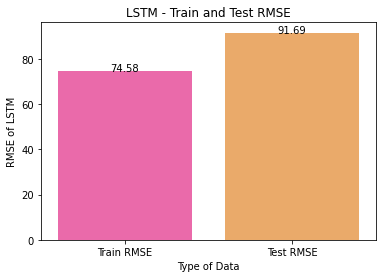

In [59]:
g = sns.barplot(x='Type of Data', y='RMSE of LSTM', data=RMSE_data_df, palette='spring')
for index, row in RMSE_data_df.iterrows():
    g.text(row.name, row['RMSE of LSTM'], round(row['RMSE of LSTM'],2), color='black', ha="center")
plt.title('LSTM - Train and Test RMSE')

Text(0.5, 1.0, 'Comparison of train and test RMSE of two algorithms')

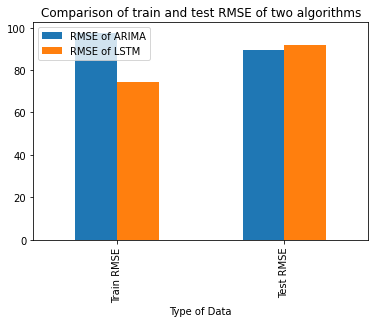

In [60]:
RMSE_data_df.plot(x="Type of Data", y=["RMSE of ARIMA", "RMSE of LSTM"], kind="bar")
plt.title('Comparison of train and test RMSE of two algorithms')

In [ ]:
# Throws an error, unsure why
sns.barplot(x='Type of Data', y=['RMSE of ARIMA', 'RMSE of LSTM'], hue='Type of Data', data=RMSE_data_df, palette='spring')